# Tutorial su API di StackExchange

**Nome**: *Luca Venerando*

**Cognome**: *Greco*

**Matricola**: *1000016165*

**Corso**: Social Media Management

**Docente**: Antonino Furnari

**Anno Accademico**: *2022/2023*

## Introduzione
StackOverflow è un sito di domande e risposte per programmatori. È la community online più grande e affidabile per gli sviluppatori per cercare, apprendere e condividere le proprie conoscenze e per costruire la propria carriera.

StackOverflow è stata fondato nel 2008 da Jeff Atwood e Joel Spolsky. Il sito è stato creato come progetto collaterale per aiutare i programmatori a trovare soluzioni ai problemi che stavano riscontrando con il loro codice.

Nel 2009 nasce StackExchange, un network di forum Q&A sullo stampo di StackOverflow riunendo sotto un'unica compagnia padre l'intero network. 

Frutto di questa centralizzazione sono le API che andremo a usare per questo tutorial, noi specificheremo sempre come `site` l'identificativo di StackOverflow ma le medesime richieste sono utilizzabili identicamente per qualunque altro forum appartenente al network 



## La prima richiesta

Come accade molto spesso nelle API pubbliche di grandi social media, StackExchange permette di interfacciarsi con il proprio db interno senza possedere alcuna forma di autenticazione, seppure in forma limitata. Approfittiamone dunque per mettere fin da subito mano su queste API e facciamo una semplicissima richiesta API che restituirà alcune informazioni sul sito di StackOverflow, come ad esempio il numero di totale di domande effettuate sul sito o la versione delle API in uso.

Per poterci aiutare a visualizzare le risposte JSON attraverso la shell del notebook definiamo una funzione ausiliaria di formattazione

In [ ]:
import json

def get_pretty_json_string(value_dict):
    return json.dumps(value_dict, indent=4, sort_keys=True, ensure_ascii=False)

Dato che la totalità delle richieste presenterà un base url comune, al fine anche di rendere facilmente aggiornabile il notebook, definiamo una variabile `base_url` che andremo poi a concatenare con gli endpoint delle specifiche richieste che andremo a fare

Useremo inoltre un dizionario di parametri che poi la libreria si occuperà di convertire in query string da appendere al nostro url

In [ ]:
import requests

base_url = "https://api.stackexchange.com/2.3/"

params = {
    'site': "stackoverflow"
}


In [ ]:
method = "info"

response = requests.request("GET", base_url + method, params=params)

print("Status code della risposta:", response.status_code)
print("Corpo della risposta:\n" + get_pretty_json_string(response.json()))


Ci troviamo davanti alla risposta in JSON che il webservice ci ha fornito in risposta alla nostra richiesta HTTP. Il formato JSON assomiglia per molti aspetti ai dizionari python, in cui si hanno coppie di chiave-valore. Data la possibilità di nidificare altri dizionari in qualità di valori di alcune chiavi, il JSON si presenta come una struttura a livelli, in particolare il primo livello contiene metadati relativi alla richiesta fatta al web service  (`has_more`, `quota_max`, `quota_remaining`) mentre una di queste key (`items`) al livello di "metadati" contiene i veri e propri dati richiesti dall'applicazione.

Considerando che i metadati ci accompagneranno per l'interezza di questo tutorial, vale la pena soffermarsi un attimo per comprendere bene il significato di ciascuno di essi.
- `has_more`: nell'eventualità in cui venisse fatta una richiesta su tabella che prevede paging questo valore ci permette di capire se la presente è l'ultima pagina o se ve ne sono altre successivamente
- `quota_max`: è il numero massimo di richieste effetuabili al giorno dallo stesso indirizzo IP
- `quota_remaining`: è il numero rimanente di richieste effettuabili in questa giornata dall'inidirizzo IP che ha fatto la richiesta

Tutto sembra essere in ordine, ma che succede se proviamo ad effettuare un richiesta diversa?

Proviamo ad esempio a richiedere lo stream dei nuovi utenti e dei nuovi contenuti che vengono generati sul sito (attraverso l'API `/events`)

In [ ]:
method = "events"

response = requests.request("GET", base_url + method, params=params)

print("Status code della risposta:", response.status_code)
print("Corpo della risposta:\n" + get_pretty_json_string(response.json()))

Come risulta immediatamente chiaro, le API anonime presentano numerose limitazioni, non solo determinate funzionalità sono completamente bloccate ma in ogni caso si è comunque fortemente limitati a 300 richieste giornaliere, che anche per un use-case giocattolo come il nostro risultano restrittive.

Vediamo allora come possiamo effettuare richieste autenticate

## Autenticazione


Prima di iniziare, ogni applicazione che voglia effettuare richieste autenticate ai webservices forniti da StackExchange deve prima munirsi di un un token di autenticazione, vediamo come fare.

Bisognerà innanzitutto recarsi sulla pagina di registrazione delle [Stack Apps](https://stackapps.com/apps/oauth/register), effettuando il login se si è gia registrati ad uno dei forum associati a StackExchange o creando un nuovo account in caso contrario.

A questo punto viene richiesto di inserire alcuni dati riguardanti la Stack App, sentitevi liberi di popolare i campi come preferite.

Se non si possiede un OAuth domain è consigliabile inserire `stackexchange.com`

**E' importante selezionare `Enable Client Side OAuth Flow`**

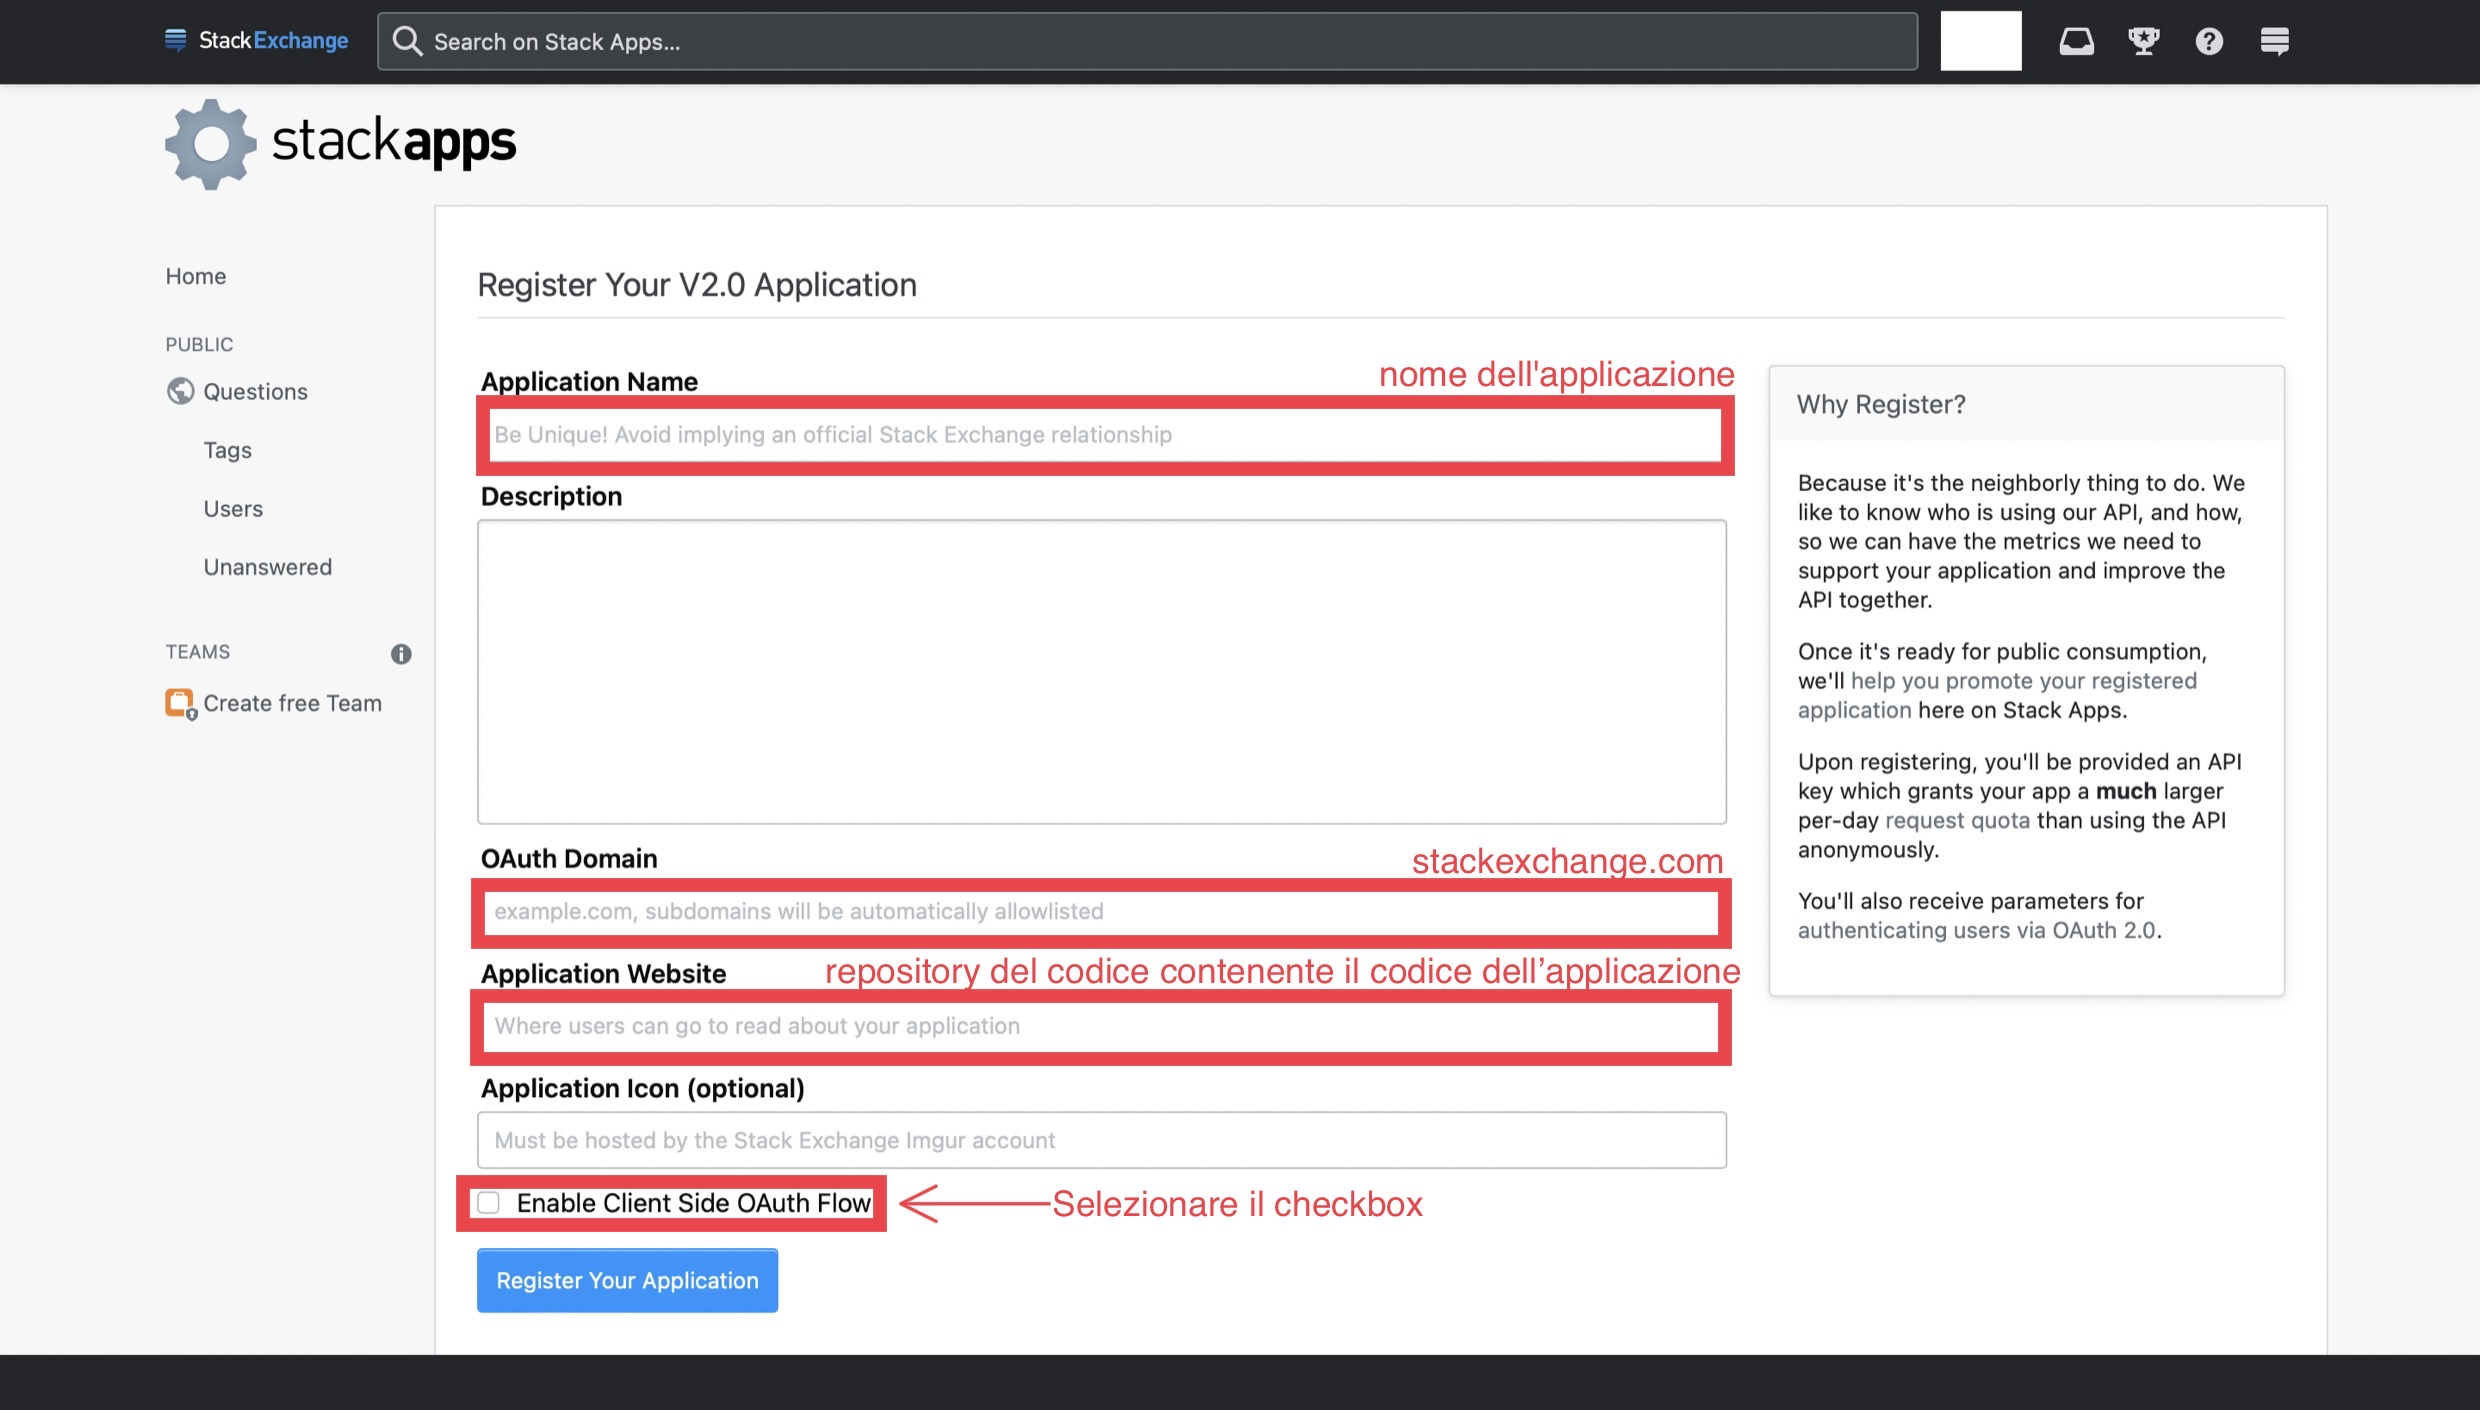

Una volta completata la registrazione vi verrano forniti una serie di parametri più o meno importanti che è bene appuntarvi, in particolare:
- Client ID
- Client Secret
- Key

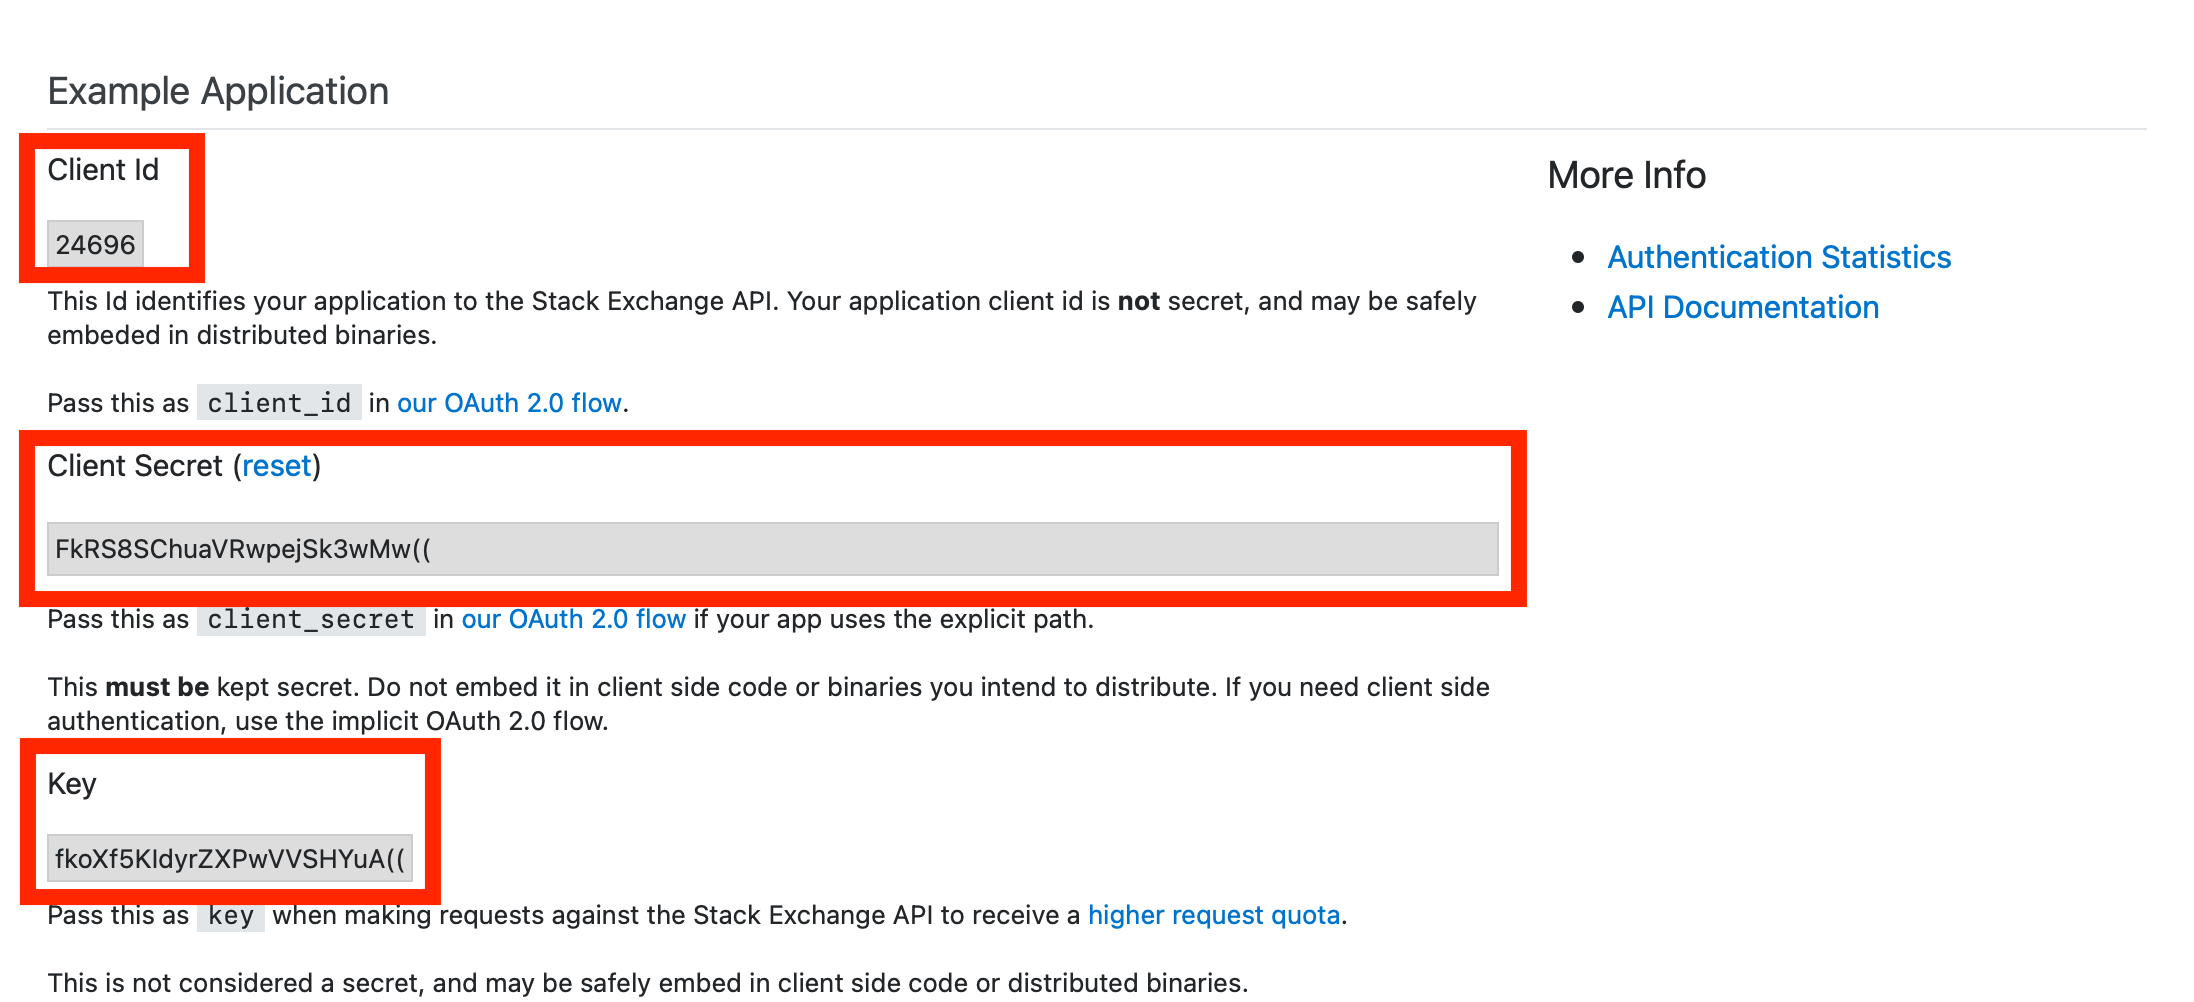

Questi verranno poi utilizzati  all'interno di tutte le nostre chiamate e associeranno quest'ultime con l'applicazione che abbiamo appena registrato su StackApps

Iniziamo dunque aggiungendo alle nostre richieste la key appena ottenuta

Riproviamo allora con la chiamata `/info`

In [ ]:
method = "info"

params['key'] = "3gYghtUtvjTT30rSGiuMyg((" # cambiare chiave con quella fornita da stackapps per la vostra applicazione

response = requests.request("GET", base_url + method, params=params)

print("Status code della risposta:", response.status_code)
print("Corpo della risposta:\n" + get_pretty_json_string(response.json()))

Bene, siamo riusciti con successo ad usare la chiave, lo si capisce semplicemente andando a guardare il campo `quota_max` che adesso si trova ad un comodo 10000

E' arrivato dunque il momento di riprovare con la richiesta sullo stream dei nuovi contenuti del forum (`/events`)

In [ ]:
method = "events"

response = requests.request("GET", base_url + method, params=params)

print("Status code della risposta:", response.status_code)
print("Corpo della risposta:\n" + get_pretty_json_string(response.json()))

I più attenti avranno già compreso il problema palesatosi, la key fornitaci su StackApps è solo un token di _autenticazione_ ma per effettuare determinate richieste dobbiamo avere un token di _autorizzazione_ <sup>[ref.](https://stackoverflow.com/a/6556548/10210279)</sup>, vediamo come ottenerlo.

## Autorizzazione

Innanzitutto si dovrà visitare un url particolare:

<span style="font-size: .7rem">`https://stackoverflow.com/oauth/dialog?client_id=`**`[client_id]`**`&redirect_uri=https://stackexchange.com/oauth/login_success&scope=read_inbox,no_expiry,private_info`</span>

Dove **`[client_id]`** va sostituito con il valore ottenuto durante la registrazione della stackApp.

Qua, dopo aver eseguito l'accesso, vi verrà richiesto di accettare che l'app acceda ad alcuni dati, accettate.

![Accept.png](./Accept.png)

A questo punto verrete portati in una pagina di stackexchange dal titolo "Authorizing Application"

L'access_token è parte dell'url della pagina in cui vi trovate:

`https://stackexchange.com/oauth/login_success#access_token=[token]`

![](./TokenURL.png)

Proviamo ad utilizzarlo dunque, ancora una volta con la query `/events`

In [ ]:
params['access_token'] = "xBLAappRlR0uHjjy0J(J*A))" # cambiare access token con quello ottenuto al passo precedente

method = "events"

response = requests.request("GET", base_url + method, params=params)

print("Status code della risposta:", response.status_code)
print("Corpo della risposta:\n" + get_pretty_json_string(response.json()))

🥳

Siamo riusciti a effettuare la nostra prima richiesta autorizzata!

Adesso abbiamo tutti gli strumenti necessari per effettuare la maggior parte delle richieste API

Come parte finale di questo tutorial cerchermo di recuperare le domande con il punteggio più alto, visualizzeremo i dati e cerchermo di analizzarli.

## I Filters

Prima di iniziare vorrei aprire una piccola parentesi su una funzionalità interessante di queste API: i [`filters`](https://api.stackexchange.com/docs/filters). `filters` è uno dei parametri popolabili delle API di StackExchange, permette di specificare un determinato filter (gia configurato da utilizzare) il quale permetterà di aggiungere o omettere qualunque valore presente all'interno delle risposte alle nostre richieste API, cosi da poter ritornare esattamente ciò di cui l'applicazione necessità risparmiando banda passante. Esistono filtri già preconfigurati ma è anche possibile crearne di nuovi con delle richieste apposite

Adesso utilizzeremo un filter gia preconfigurato, il filtro `total`, il quale ci permetterà di aggiungere il campo total alla `response wrapper` per ottenere il numero di righe totali della query.

Un parte essenziale del processo di approccio alla analisi dei dati consiste sicuramente nell'apprezzarne la mole, propongo quindi di seguito una piccola richiesta utilizzante il filtro `total` per capire quante nuove domande siano state aperte nell'ultima settimana

In [ ]:
from datetime import datetime, timedelta

method = "questions"

now = datetime.now()
starting_date = now - timedelta(days=7)

question_params = params | {
        'order': "desc",
        'sort': "votes",
        'pagesize': 100,
        'fromdate': int(starting_date.timestamp()),
        'todate': int(now.timestamp()),
        'filter': "total"
    }



response = requests.request("GET", base_url + method, params=question_params)

print("Status code della risposta:", response.status_code)
print("Corpo della risposta:\n" + get_pretty_json_string(response.json()))

Com'era prevedibile, anche solo le domande effettuate in una sola settimana sono dell'ordine delle migliaia e decisamente fuori dalla portata del nostro piccolo tutorial, inoltre con ogni probabilità la maggior parte di questi dati saranno garbage, o perchè duplicati o perchè domande banali. 

Possiamo tuttavia pensare di sfruttare questi filters creando la risposta tipo ideale per la nostra applicazione, vediamo come fare:

In [ ]:
method = "filters/create"

wrapper =  ".backoff;.error_id;.error_message;.error_name;.has_more;.items;.quota_max;.quota_remaining;";
question = "question.tags;question.owner;question.score;question.creation_date;question.link;question.question_id;"
owner = "shallow_user.user_id;shallow_user.display_name;shallow_user.reputation;shallow_user.link"


filter_params = {
        'base': "none",
        'include': wrapper + question + owner
    }

response = requests.request("GET", base_url + method, params=filter_params)

custom_filter = response.json()['items'][0]['filter']

print("Status code della risposta:", response.status_code)
print("Corpo della risposta:\n" + get_pretty_json_string(response.json()))

Come potete vedere i campi inclusi all'interno del nostro filtro ricadono in tre categorie:
- `wrapper`
- `question`
- `owner`

Per il primo ci siamo limitati a mantenere i campi che di default sarebbero stati inclusi, questi risultano di fatto essenziali per poter diagnosticare eventuali errori all'interno delle nostre chiamate ed anche per poter tenere sotto controllo il nostro usage giornaliero. Importante aggiunta risulta il campo di backoff, che era sempre presente anche prima ma che non veniva popolato dal webservice; il campo di backoff è cruciale per un buon utlizzo delle api, le quali nell'eventualità in cui si effettuino troppe chiamate consecutivamente popoleranno il campo suggerendo al client di attendere alcuni secondi prima di effettuare la richiesta succesiva.

Per quanto riguarda i campi delle domande abbiamo deciso di tenere alcuni dati cruciali relativi alle stesse che verranno succesivamente analizzate nel dettaglio, abbiamo inoltre aggiunto alcune informazioni sull'utente che ha creato la domanda.

## Data retrieval

A questo punto ci approcciamo alla fase di acquisizione dei dati, per mostrare la potenza dei dati offerti, si è deciso di analizzare le 1000 domande con score più alto e cercare di comprenderne la natura statistica ed eventuali relazioni con altre parti del sito. Procediamo dunque alla scrittura della richiesta API

Come si può notare ogni singola richiesta è limitata ad appena 100 righe (domande) di risposta ma chiaramente sarebbe più proficuo poter ottenere più dati; ovviamente ripetere la medesima richiesta continuerà a ritornare sempre le stesse 100 righe, non ad esempio la 101esima. 

Per ovviare a questo problema le API di StackExchange mettono a disposizione un sistema di paging, in cui la totalità dei dati viene raccchiusa all'interno di pagine aventi un numero di righe pari a `pagesize` ed è possibile richiedere un qualunque page number utilizzando l'apposito campo dell'API `page`, dunque dopo aver letto la prima pagina, potremmo richiedere la seconda, la terza e cosi via.

A questo punto si palesa il problema di capire se il db contenga una pagina successiva o se siano effettivamente finite, per fare ciò sfrutteremo il metadato `has_more` cui avevamo accennato precedentemente per iterare la medesima richiesta fino all'esaurimento dei dati recuperabili

In [ ]:
import time

method = "questions"

num_pages = 100

question_params = params | {
        'order': "desc",
        'sort': "votes",
        'pagesize': 100,
        'filter': custom_filter
    }

all_questions = []

for page in range (1, num_pages):
    question_params['page'] = page
    response = requests.request("GET", base_url + method, params=question_params)
    all_questions.extend(response.json()['items'])
    if "false" == str(response.json()['has_more']).lower():
        break
    if 'backoff' in response.json():
        time.sleep(response.json()['backoff'])


Per evitare di dover aspettare la lenta risposta dei server si consiglia di salvare il dizionario su un file di testo e successivamente ricaricarlo piuttosto che ottenere continuamente dati direttamente dalle API 

In [ ]:
#load json file
import json

# if json file exists, load it
try:
    # open json file
    with open('questions.json') as json_file:
        data = json.load(json_file)
    
except FileNotFoundError:
    # write all_question to json file
    with open('questions.json', 'w') as outfile:
        json.dump(all_questions, outfile)
        data = all_questions


## Analisi dei dati

Ora che abbiamo tutti i dati a nostra disposizione possiamo iniziare ad analizzarli. 

Prima di tutto definiamo alcune funzioni ausiliari di statistica per ripulire i dati, definiamo quindi una semplice funzione per rimuovere gli outliers usando i quartili. 

In [ ]:
import numpy as np


def boundaries(values):
    #calculate quartiles
    q1 = np.percentile(values, 25)
    q3 = np.percentile(values, 75)
    iqr = q3 - q1

    #ruturn boundaries
    return q1 - iqr, q3 + iqr

def lower_bound(values):
    return boundaries(values)[0]

def upper_bound(values):
    return boundaries(values)[1]

def rmoutliers(*args):
    #calculate boundaries
    arrays = list(args)
    for arr in arrays:
        filter_matrix = (arr < upper_bound(arr)) & (arr > lower_bound(arr))
        for i, _ in enumerate(arrays):
            arrays[i] = arrays[i][filter_matrix]
    return arrays

Iniziamo visualizzando alcuni dati banali, come la distribuzione degli score o la correlazione fra lo score dei post e la reputazione degli utenti.

Per la prima ci aspettiamo di guardare una Gaussiana o una Poissoniana mentre per il secondo una evidente correlazione lineare. 

N.B: rimuoveremo gli outlier dagli score

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime

num_pages = 100

#split plots
fig, axs = plt.subplot_mosaic("AB", figsize=(15, 5))

scores = np.fromiter(map(lambda x: x['score'], data), dtype=int)
#Remove outliers
scores = rmoutliers(scores)[0]

#plot 1
axs['A'].hist(scores, bins=100)
axs['A'].set_title('Questions\' scores distribution')
axs['A'].set_xlabel('Score')
axs['A'].set_ylabel('Frequency')

compound = np.fromiter(
    ([(x['owner']['reputation'], x['score']) for x in data if 'owner' in x and 'reputation' in x['owner'] ]),
    dtype=[('reputation', int), ('score', int)]
    )


reputation, question_score = compound['reputation'], compound['score']

axs['B'].scatter(reputation, question_score, s=3)
axs['B'].set_title('Creator reputation vs score')
axs['B'].set_xlabel('Creator reputation')
axs['B'].set_ylabel('Score')
#axs['B'].set_yscale('log')
#axs['B'].set_ylim(0, 10000)

plt.tight_layout()
plt.show()

Vediamo adesso di estrarre alcuni dati cruciali come ad esempio i tag più frequenti, spesso utilizzati come metrica di popolarità fra i linguaggi di programmazione

In [ ]:
fig, axs = plt.subplot_mosaic("C", figsize=(15, 5))

#get tags counting
repeated_tags = np.fromiter( ([tag for x in data for tag in x['tags']] ), dtype = object)

unfiltered_tags, tags_count =  np.unique(repeated_tags, return_counts=True)

filter_matrix = tags_count > num_pages
tags, tags_count = unfiltered_tags[filter_matrix], tags_count[filter_matrix]
sorted_indexes = np.argsort(tags_count)[::-1]
tags_count, tags = tags_count[sorted_indexes], tags[sorted_indexes]

#plot tags distribution
axs['C'].bar(tags, tags_count)
axs['C'].set_title('Tags distribution')
axs['C'].set_xlabel('Tag')
axs['C'].set_ylabel('Frequency')
axs['C'].tick_params(axis='x', labelrotation=90, labelsize=10)

plt.tight_layout()
plt.show()

Come ci aspettavamo i linguaggi di programmazione più popolari sono anche i più frequenti, notabile la presenza di git così in alto ma comprensibile considerando l'onnipresenza del tool negli ambienti di programmazione. 

Infine, cerchiamo di capire se esistono finestre temporali ad alto traffico; sarebbe verosimile aspettarsi un declino durante il periodo natalizio e quello estivo, plottiamo quindi la quantità di domande richieste durante l'anno usando bin bi-settimanali

In [ ]:

fig, axs = plt.subplot_mosaic("D", figsize=(15, 5))

dates = np.fromiter(map(lambda x: datetime.fromtimestamp(x['creation_date']).timetuple().tm_yday, data), dtype=int)
#plot dates distribution
axs['D'].hist(dates, bins=365//2)
axs['D'].set_title('Questions\' creation dates distribution')
axs['D'].set_xlabel('Day of the year')
axs['D'].set_ylabel('Frequency')        

plt.tight_layout()
plt.show()

Effettivamente non vediamo alcun pattern particolarmente rilevante, forse un piccolo picco intorno ai primi di settembre, forse compatibile con un ipotetico ritorno dalla pausa estiva

## Il wrapper 

Prima di concludere mi sembra doveroso citare un wrapper python per le API di StackExchange: [StackAPI](https://stackapi.readthedocs.io/en/latest/user/intro.html).


Iniziamo installando il pacchetto:

`$ pip install stackapi`

Iniziamo ripetendo le prime richieste di questo tutorial



In [ ]:
from stackapi import StackAPI

SITE = StackAPI('stackoverflow', key = params['key'], access_token=params['access_token'])

info = SITE.fetch('info')

print(get_pretty_json_string(info))

Come si può vedere il wrapper presenta un'interfaccia più semplice e intuitiva da utilizzare, oltre a numerose altre funzionalità, come una gestione ad oggetti degli errori o l'adattamento automatico ai tempi di backoff

## Conclusioni

Le API di StackExchange sono sicuramente fra le API meglio documentate che esistano, probabilmente l'unico difetto reale dell'intero sistema risiede nella mole limitata di dati ottenibile in breve tempo (a causa dei tempi di backoff) ma a questo si può porre rimedio grazie al [data explorer](https://data.stackexchange.com) fornito dalla stessa società. 

Vagamente laborioso anche l'ottenimento  dell'access token ma che comunque resta in linea con altri metodi di autenticazione di altre grandi società.

In generale, il database di domande e risposte di StackOverflow è una delle più grandi miniere di conoscenza per qualunque argomento concerne la programmazione e di certo una delle più grandi conquiste di internet.